# Calculation of single score endpoint weights

To combine all endpoints into a single score, we need to do two things:

1. Normalize scores so that the three endpoints are in the same relative range. Otherwise, if one category has significanlty higher numbers (and the units are *completely* different!) will always dominate, regardless of the weights chosen.
2. Weight the three endpoints: Ecosystems, human health, and resources.

In general, after reading the above you should be thinking to yourself that this all feels a bit sketchy - it is. It is quite difficult to meaningfully combine e.g. DALYs and species extinction. But sometimes you want that vintage feeling in your LCA studies...

In [1]:
%matplotlib inline

In [2]:
import bw2data, bw2calc
import numpy as np
import seaborn as sb
import pyprind
from matplotlib import pyplot as plt

db = bw2data.Database("ecoinvent 3.6 cutoff")
methods = [
    ('ReCiPe 2016', 'v1.1 (20180117)', 'Endpoint', 'Human health', 'Aggregated', 'Hierarchist'),
    ('ReCiPe 2016', 'v1.1 (20180117)', 'Endpoint', 'Resources', 'Aggregated', 'Hierarchist'),
    ('ReCiPe 2016', 'v1.1 (20180117)', 'Endpoint', 'Ecosystems', 'Aggregated', 'Hierarchist')
]

In [3]:
lca = bw2calc.LCA({db.random(): 1}, methods[0])
lca.lci()
lca.lcia()

In [4]:
matrices = []

for m in methods:
    lca.switch_method(m)
    matrices.append(lca.characterization_matrix.copy())
   
# Make sure they are actually different
[x.sum() for x in matrices]

[2101.531282617175, 7295.913837048749, 0.001284508112345826]

In [5]:
results = np.zeros((len(db), len(methods)))

In [6]:
for i, act in enumerate(pyprind.prog_bar(db)):
    lca.redo_lci({act: 1})
    for j, m in enumerate(matrices):
        results[i, j] = (m * lca.inventory).sum()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:07:05


In [7]:
np.save("comparative-results.npy", results)

In [8]:
results = np.load("comparative-results.npy")

Provided value is 3.08E10 for extinction of one species, but we have regionalized extinction per region in one year. I divided by 1000 to convert to species\*year, though admittedly this is arbitrary.

In [9]:
aggregated = results[:, 0] * 7.4E4 + results[:, 1] + results[:, 2] * 3.08E7

# Human health

In [10]:
weighted_relative_scores = (results[:, 0] * 7.4E4) / aggregated

50 29


Text(0.5, 0, 'Fraction of weighted total impact')

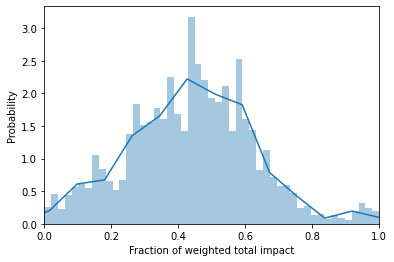

In [11]:
print((weighted_relative_scores < 0).sum(), (weighted_relative_scores > 1).sum())

sb.distplot(weighted_relative_scores, bins=np.linspace(0, 1, 50))
plt.xlim([0, 1])
plt.ylabel("Probability")
plt.xlabel("Fraction of weighted total impact")

# Resources

In [12]:
weighted_relative_scores = (results[:, 1]) / aggregated

103 1


Text(0.5, 0, 'Fraction of weighted total impact')

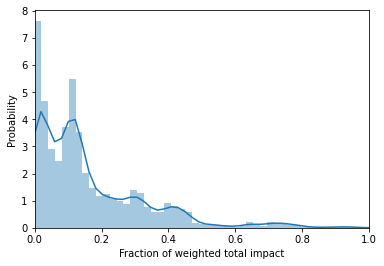

In [13]:
print((weighted_relative_scores < 0).sum(), (weighted_relative_scores > 1).sum())

sb.distplot(weighted_relative_scores, bins=np.linspace(0, 1, 50))
plt.xlim([0, 1])
plt.ylabel("Probability")
plt.xlabel("Fraction of weighted total impact")

# Ecosystems

In [14]:
weighted_relative_scores = (results[:, 2] * 3.08E7) / aggregated

29 58


Text(0.5, 0, 'Fraction of weighted total impact')

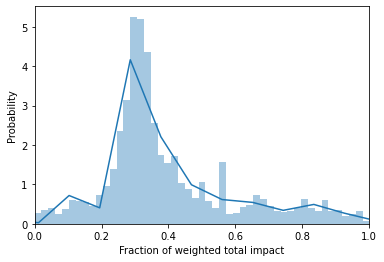

In [15]:
print((weighted_relative_scores < 0).sum(), (weighted_relative_scores > 1).sum())

sb.distplot(weighted_relative_scores, bins=np.linspace(0, 1, 50))
plt.xlim([0, 1])
plt.ylabel("Probability")
plt.xlabel("Fraction of weighted total impact")

# Check implementation in a single score

In [4]:
lca.score

3.6542864298022714e-08

In [5]:
manual = 0

inputs = [
    ('ReCiPe 2016', 'v1.1 (20180117)', 'Endpoint', 'Human health', 'Aggregated', 'Hierarchist'),
    ('ReCiPe 2016', 'v1.1 (20180117)', 'Endpoint', 'Resources', 'Aggregated', 'Hierarchist'),
    ('ReCiPe 2016', 'v1.1 (20180117)', 'Endpoint', 'Ecosystems', 'Aggregated', 'Hierarchist')
]
weights = [7.4E4, 1, 3.08E7]

for x, y in zip(inputs, weights):
    lca.switch_method(x)
    lca.redo_lcia()
    manual += lca.score * y

lca.switch_method(('ReCiPe 2016', 'v1.1 (20180117)', 'Endpoint', 'Weighted single score', 'Aggregated', 'Hierarchist'))
lca.redo_lcia()
print(lca.score, manual)

0.00963518531723127 0.009635185445195385
